# Transfer Learning

Este tutorial fue elaborado a partir de las siguientes fuentes:

* [Deep Learning For Beginners Using Transfer Learning In Keras](https://towardsdatascience.com/keras-transfer-learning-for-beginners-6c9b8b7143e)
* [A Comprehensive Hands-on Guide to Transfer Learning with Real-World Applications in Deep Learning](https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a)
* [Transfer Learning Introduction](https://www.hackerearth.com/practice/machine-learning/transfer-learning/transfer-learning-intro/tutorial/)
* [Keras: Feature extraction on large datasets with Deep Learning](https://www.pyimagesearch.com/2019/05/27/keras-feature-extraction-on-large-datasets-with-deep-learning/)
* [Transfer learning from pre-trained models](https://towardsdatascience.com/transfer-learning-from-pre-trained-models-f2393f124751)


## ¿Qué es Tranfer Learning?

Si bien el entrenamiento de una CNN desde cero es posible para proyectos con datasets pequeños, la mayoría de las aplicaciones requieren enormes cantidades de datos procesados ​​y mucha potencia computacional. Ahí es donde entra en juego *transfer learning* (TL) o *aprendizaje de transferencia*. Su definición es la siguiente:

> **Situación en la que se aprovecha lo aprendido en un entorno para mejorar la generalización en otro entorno**

En el contexto de deep learnig, TL implica tomar un modelo ya entrenado para un problema específico, y usar sus parámetros como parte del aprendizaje de un nuevo modelo en otro problema diferente.

De esta manera, TL tiene las siguiente ventajas:

1. Se puede entrenar con **datasets mucho más pequeños**.
2. Requiere **mucha menos potencia computacional**, ya que usamos parámetros pre-entrenados.

## ¿Por qué TL funciona bien?

Como vimos en los laboratorios anteriores, el objetivo de entrenar una CNN es encontrar los valores óptimos en cada una de las matrices de filtro que se han definido en la arquitectura de la red (es decir, los parámetros del modelo). Cuando observamos qué han aprendido a reconocer los filtros en cada capa de la CNN, o por qué se activa cada filtro, podemos ver cosas realmente interesantes.

![](https://miro.medium.com/max/2177/1*jPCEik198_CjtmSL2H6o4g.png)

Los filtros en las primeras capas de la CNN aprenden a reconocer **colores** y ciertas **líneas horizontales y verticales**. Las siguientes capas aprenden a reconocer **formas sencillas** usando las líneas y los colores aprendidos en las capas anteriores. 

![](https://miro.medium.com/max/1963/1*1Y6HZxK-lOmqB8KnizTCow.png)

Luego, las siguientes capas aprenden a reconocer **texturas**, luego **partes de objetos** como piernas, ojos, nariz, etc. Finalmente, los filtros en las últimas capas se activan por **objetos completos** como perros, automóviles, etc.

Cuando los investigadores comenzaron a observar que es lo que las CNN aprendían, notaron que redes entrenadas con datasets de imágenes diferentes exhibían un fenómeno curioso en común: las características de las primeras capas **no parecen ser específicas de un dataset en particular, si que son genéricas**, y por lo tanto son aplicables a muchos problemas. 

Y es éste fenómeno el que se aprovecha para hacer TL cuando usamos CNN para procesamiento de imágenes. Básicamente, primero se entrena una *red base* sobre un *dataset base*, y luego se reutilizan las características aprendidas en una segunda *red específica* para que se entrene con un nuevo *dataset específico*. Este proceso tenderá a funcionar si las características son generales, es decir, adecuadas para el problema original y problema el nuevo.

# Transfer Learning con una CNN pre-entrenada


Tutorial extraído de https://www.tensorflow.org/tutorials/images/transfer_learning

En este tutorial vamos a clasificar imágenes de gatos vs perros utilizando TL de una red pre-entrenada. Como ya vimos antes, la intuición detrás de TL es que si un modelo es entrenado con un dataset lo suficientemente grande y general, el modelo servirá efectivamente como un modelo genérico del *mundo visual*. Luego, se puede aprovechar los *feature maps* aprendidos sin tener que comenzar desde cero a entrenar un nuevo modelo.

En este laboratorio, vamos a ver dos formas de hacer TL con un modelo previamente entrenado:

1. **Extracción de características**: utiliza los filtros aprendidos por una red para extraer características significativas de nuevas imágenes. Simplemente se agrega un nuevo clasificador que se entrenará desde cero, encima del modelo previamente entrenado para que pueda reutilizar los feature maps aprendidos previamente para un nuevo dataset.
![](https://ujwlkarn.files.wordpress.com/2016/08/screen-shot-2016-08-07-at-9-15-21-pm.png?w=1496)
No es necesario (re) entrenar todo el modelo. La CNN base ya contiene características que son genéricamente útiles para clasificar imágenes. Sin embargo, la parte final de la clasificación del modelo preentrenado es específica de la tarea de clasificación original y, posteriormente, específica del conjunto de clases en las que se entrenó el modelo.

2. **Ajuste fino**: *descongela* algunas de las capas superiores de una CNN base y entrena conjuntamente las capas del clasificador recién agregadas y las últimas capas de la CNN base. Esto permite *ajustar* las representaciones de características de orden superior en el modelo base para hacerlas más relevantes para la tarea específica.

El flujo de trabajo general que vamos a seguir es el siguiente:

1. Examinar y comprender los datos.
2. Crear una *tubería de entrada*, en este caso utilizando el objeto `ImageDataGenerator` de la librería Keras.
3. Compliar el nuevo modelo: carga modelo base previamente entrenado y agregar nuevas capas de clasificación en la parte superior.
4. Entrenar el nuevo modelo.
5. Evaluar el modelo.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os

import numpy as np

import matplotlib.pyplot as plt

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

keras = tf.keras

## Preprocesamiento de los datos

### Descargar los datos

Vamos a utilizar [TensorFlow Datasets](http://tensorflow.org/datasets) para cargar el dataset de gatos y perros.

El paquete `tfds` es la forma más fácil de cargar datos predefinidos. Si tiene sus propios datos y está interesado en importarlos con TensorFlow, se pude consultar el tutorial [Load images](https://www.tensorflow.org/tutorials/load_data/images)


In [4]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

El método `tfds.load` descarga y almacena los datos en caché, y devuelve un objeto` tf.data.Dataset`. Estos objetos proporcionan métodos potentes y eficientes para manipular datos y canalizarlos a un modelo.

Primero tenemos que dividir el dataset `cats_vs_dog` en 3 conjuntos: entrenamiento, validación y prueba. Para esto usamos la función de subdivisión para dividir el dataset: 80%, 10%, 10% de los datos en cada conjunto respectivamente.

In [5]:
# Split the dataset into train, validation and test
splits=['train[:80%]', 'train[80%:90%]', 'train[90%:]']

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs', split=list(splits), with_info=True, as_supervised=True)

Shuffling and writing examples to /home/andres/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteJEY7N4/cats_vs_dogs-train.tfrecord
Dataset cats_vs_dogs downloaded and prepared to /home/andres/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


Los objetos resultantes `tf.data.Dataset` contienen pares `(imagen, etiqueta) `. Donde las imágenes tienen *forma variable* y 3 canales, y la etiqueta es un escalar.

In [6]:
num_classes = metadata.features['label'].num_classes
print("Number of classes:", metadata.features['label'].num_classes)

Number of classes: 2


Mostramos las 3 primeras imágenes y etiquetas del conjunto de entrenamiento:

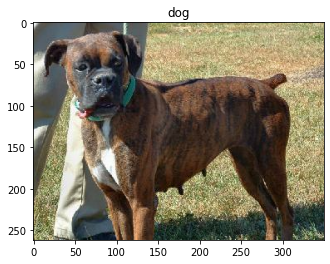

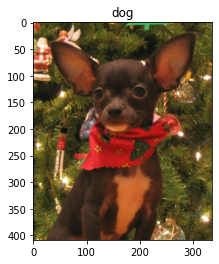

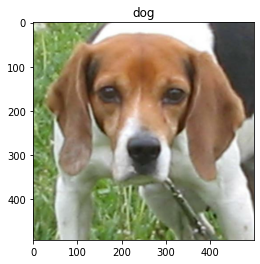

In [7]:
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(3):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

### Formatear los datos

Usamos el módulo `tf.image` para formatear las imágenes para nuestro problema. Primero cambiamos el tamaño de las imágenes a un tamaño de entrada fijo, y luego cambiamos la escala de los canales de entrada a un rango entre `[-1,1]`.

In [8]:
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

Aplicamos el formateo a cada imagen en el dataset utilizando el método de `map` de la clase `tf.data.Dataset`:

In [9]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

Ahora mezclamos y procesamos los datos por lotes.

In [10]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [11]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

Inspeccionamos un lote de datos:

In [12]:
for image_batch, label_batch in train_batches.take(1):
   pass

image_batch.shape

TensorShape([32, 160, 160, 3])

## Crear la modelo base a partir de una CNN previamente entrenada

Ahora vamos a crear nuestro modelo base a partir de la CNN **MobileNet V2**, desarrollada en Google. 

![](https://machinethink.net/images/mobilenet-v2/Classifier@2x.png)

Esta CNN está pre-entrenada con el dataset [ImageNet](https://image-net.org), un dataset con 1.4 millones de imágenes distribuídas en 1000 clases. ImageNet tiene un conjunto de datos para investigación bastante variado, con categorías como `jackfruit` y` syringe`. Sin embargo, esta *base de conocimiento* nos ayudará a distinguir a los gatos y los perros en nuestro dataset específico.

Primero, debemos elegir qué capa de *MobileNet V2* se usará para la extracción de características. Obviamente, la última capa de clasificación no es muy útil. En su lugar, vamos a a tomar la última capa antes de la operación de aplanar (`flatten`). Esta capa se llama *bottleneck layer* (cuello de botella). Las características de la capa bottleneck conservan mucha generalidad en comparación con la capa final.

Para esto vamos a crear una instancia del modelo MobileNet V2 con parámetros ya entrenados sobre el dataset ImageNet. Al especificar el argumento `include_top = False`, carga la red sin incluir las capas de clasificación, lo que es ideal para la extracción de características.

In [13]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 1s 0us/step


Este extractor de características convierte cada imagen de `160x160x3` en un bloque de features de `5x5x1280`. Podemos ver esto reflejado en la forma del lote de imágenes de ejemplo:

In [14]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## Extracción de características

Ahora vamos a *congelar* la *base convolucional* creada a partir de la etapa anterior, y luego vamos a usar eso como un extractor de características, añadir un clasificador en la parte superior de la misma y entrenar el nuevo clasificador.

### Congelar la base convolucional

Es importante congelar la base convolucional antes de compilar y entrenar el modelo. Al congelar evitamos que los parámetros en una capa determinada se actualicen durante el entrenamiento. MobileNet V2 tiene muchas capas, por lo que vamos a establecer el argumento `layer.trainable = False` para congelar todas las capas.

In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

### Agregar un nuevo clasificador

Para generar predicciones a partir del bloque de características vamos a diseñar una nueva ANN.

La primera capa de la ANN toma el promedio para cada feature map de `5x5` que entrega la última capa de MabileNet V2. Para esto agregamos al modelo una capa `tf.keras.layers.GlobalAveragePooling2D`, que convierte los features maps en un solo vector de 1280 elementos por imagen.

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

Agregamos una capa `tf.keras.layers.Dense` para convertir estas características en una sola predicción por imagen. No necesita una función de activación aquí porque esta predicción se tratará como un `logit`: los números positivos predicen la clase 1, los números negativos predicen la clase 0.

In [ ]:
prediction_layer = keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

Ahora apilamos el extractor de características y estas dos capas usando un modelo `tf.keras.Sequential`:

In [ ]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

### Compilar el modelo

Debemos compilar el modelo antes de entrenarlo. Como hay dos clases, usamos una función de pérdida binaria.

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Los 2.5M de parámetros en MobileNet están congelados, pero hay 1.2K *parámetros entrenables* en la capa densa.

### Entrenar el modelo

Después de entrenar durante 10 epoch, deberíamos obtener una precisión cercana al 96%.

In [ ]:
num_train, num_val, num_test = (
  metadata.splits['train'].num_examples*weight/10
  for weight in SPLIT_WEIGHTS
)

In [ ]:
initial_epochs = 10
steps_per_epoch = round(num_train)//BATCH_SIZE
validation_steps = 20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

In [ ]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

### Curvas de aprendizaje

Veamos las curvas de aprendizaje para accuracy/loss sobre los conjuntos de entrenamiento y validación cuando se usa el modelo base MobileNet V2 como un extractor de características fijas.

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Resumen:

**Uso de un modelo previamente entrenado para la extracción de características**: Cuando se trabaja con un dataset pequeño, es común aprovechar las características aprendidas por un modelo entrenado en un dateset más grande en el mismo dominio del problema. Esto se hace creando instancias del modelo pre-entrenado y agregando un clasificador completamente conectado en la parte superior (al final). El modelo pre-entrenado está *congelado* y solo los pesos del clasificador se actualizan durante el entrenamiento.
En este caso, la base convolucional extrajo todas las características asociadas con cada imagen y solo entrenó a un clasificador que determina la clase de imagen dado ese conjunto de características extraídas.

---

## **Ejercicio 3.1** (OPCIONAL)

Utilizar MobileNet v2 y los conceptos de Transfer Learning revisados en el tutorial anterior para entrenar un clasificador binario para el dataset que puede [descargar en este link](https://drive.google.com/file/d/11CTzx2PVxMhU4mvBWOZcJAx1nRM03l86/view?usp=sharing).

**NOTA**: Recuerden que deben reemplazar la cadena "/content/drive/My Drive/PATH_TO_DATASET" por el path al directorio del dataset

In [ ]:
# EJERCICIO 1

# Montamos la unida de Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Seteamos el directorio de trabajo 
%cd "/content/drive/My Drive/PATH_TO_DATASET"
!ls

In [ ]:
# Importamos librerias de Python

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
keras = tf.keras

from __future__ import absolute_import, division, print_function, unicode_literals
from PIL import Image
import IPython.display as display
import os
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import tensorflow_datasets as tfds

In [ ]:
## FUNCIONES AUXILIARES

# Obtiene la etiqueta de una imagen a partir del directorio que la contiene
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, '/')
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

# Procesa una imagen para adecuarla a la estructura de datos de entrada de la CNN
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range (luego se multiplica por 2 y se resta 1 para dejarlo en el rango [-1,1]).
  img = (tf.image.convert_image_dtype(img, tf.float32)*2)-1
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_SIZE, IMG_SIZE])

# Devuelve una imagen y su etiqueta a partir del directorio que recibe como argumento
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label  

In [ ]:
# Path al directorio que contiene el dataset de imágenes
data_dir = pathlib.Path("/content/drive/My Drive/PATH_TO_DATASET")

image_count = len(list(data_dir.glob('*/*.jpg')))
print("Cantidad de imágenes:", image_count)
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
print("Clases:", CLASS_NAMES)

# Carga la lista de imágenes 
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

# Tamaño al que se van a redimensionar las imágenes
IMG_SIZE = 160

# Carga las imagenes del dataset junto a sus etiquetas y lo desordena
labeled_ds = list_ds.map(process_path)
labeled_ds.shuffle(1000)

# Divide el dataset en 3 conjuntos
train_size = int(0.6 * image_count)
val_size = int(0.2 * image_count)
test_size = int(0.2 * image_count)

print("Cantidad de imágenes para entrenamiento:", train_size)
print("Cantidad de imágenes para validación:", val_size)
print("Cantidad de imágenes para testeo:", test_size)

train = labeled_ds.take(train_size)
test = labeled_ds.skip(train_size)
val = test.skip(val_size)
test = test.take(test_size)

# Muestra 4 imágenes tomadas aleatoriamente del dataset 
for image, label in labeled_ds.take(4):
  plt.figure()
  plt.imshow(image)
  plt.title(CLASS_NAMES[label.numpy()])



In [ ]:
# Crea los BATCHES para cada conjunto
BATCH_SIZE = 10
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = val.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

# Congela el modelo base (feature extraction)
base_model.trainable = False

# Let's take a look at the base model architecture
base_model.summary()

In [ ]:
# Crea la primera capa de la ANN que vamos a usar como clasificador
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

# Crea la capa de salida de la ANN que vamos a usar como clasificador
prediction_layer = keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)

# Apila el extractor de características y las dos capas de la ANN
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

# Compila el modelo antes de entrenarlo. Como hay dos clases usamos una función de pérdida binaria
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Let's take a look at the complete model architecture
model.summary()

In [ ]:
initial_epochs = 10
steps_per_epoch = round(train_size)//BATCH_SIZE
validation_steps = 20

history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## **Ejercicio 3.2** (OPCIONAL)

Utilizar MobileNet v2 como modelo base como extractor de características y reemplace el clasificador construido mediante una ANN en el tutorial anterior con un clasificador [SVM](https://scikit-learn.org/stable/modules/svm.html). Verificar la performance del clasificador para el dataset `dogs_vs_cats` y dataset del ejemplo anterior.

In [ ]:
# EJERCICIO 2
